# Bayesian tensorflow processing network
In this example we accomplish a number of goals.
1. the creation of two  Processing Nodes
2. how to buffer data
3. How to train a model
4. how to draw predictions
5. how to retrieve results
6. model evaluation and accuracy

Overall, this example should illustrate how to migrate any machine learning approach into a real-time production algorithm that uses processing networks. Before understanding this document, two other notebooks should be studied.

1. In the processingNetwork repository, complete the basic processing network notebook
2. In the nodes repository, review the BRNode notebook

This notebook combines both notebooks and shows usage of the BatchRegressionNode for processingNetworks

# 1 processingNetworks overview
a ProcessingNetwork is defined as a graph of processing nodes. This the basic elements of a processing network is:
1. A processingNetwork object
2. A collection of processingNode objects

## 1.1 processingNetwork
A processing network class is a container. The primary function of each processingNetwork is to process data, while resolving dependencies. Upon construction, a processingNetwork takes in a json dependency dictionary tree. 



In [1]:
class ExampleClass:
    pass
networkDef = {}
networkDef['ExampleNode'] = {'name': 'ExampleNode',
                          'type': ExampleClass,
                          'settings': {'trainCount':50,
                                       'testCount':100,
                                       'input':'data',
                                       'predictionLength':5},
                          'dependencies': []
                            }

Each element in the tree describes a node completely. In the previous example, the name of the Node is 'BatchRegressionNode', the type is a processingNode subclass called BatchRegressionNode. That subclass takes a collection of settings.

When the defintion is complete, the network can be used by instancing a network and filtering data (real example starts in Section 2.)

In [2]:
class ProcessingNetwork:
    def __init__(self,settings):
        pass
    def process(self,feature):
        # The system resolves all dependencies 
        feature['output'] = 1000 
        return feature

pn=ProcessingNetwork(networkDef)
feature = {'data':[1234]}
feature = pn.process(feature)
display(feature)


{'data': [1234], 'output': 1000}

Below is a full working example of using processingNetworks with the BayseanRegressionNode.

# 1 Creating Example Processing Nodes
Here LoadData and BatchRegressionNode are created. LoadData loads in data to be predicted. BatchRegressionNode learns a pattern from the data.

In [3]:
import sys
sys.path.append("/home/paxml-user/")

from processingNetwork import *
from processingNetwork.LinearFitNetwork import *
import pprint
import numpy as np
import pandas as pd


Here we create a LoadData step for the example  baysean linear network.  

In [4]:


# ---> LoadData ---> 
class LoadDataBayesian(ProcessingNode):
    def do_init(self):
        pass
    def do_process(self,feature):
        feature_dict=feature[self.settings['input']].copy()
        self.setValue(feature_dict)
        self.set(key='',dictData=feature_dict)
        self.set(key='test',dictData="test_value")
        return feature


For this example we create a default data emitter function:

In [5]:

# This builds a random dataset with a linear relationship underneath, governed by y= w*x + b
def build_toy_dataset(N, w, noise_std=0.01):
    D = len(w)
    x = np.random.randn(N, D)*5
    
    y = np.dot(x, w) 
    y = y  + np.random.normal(0, noise_std, size=N)
    return x, y


# 2 Creating Example ProcessingNetwork 
With the new node defined, it is possible to define the network:

In [6]:
def defaultNetworkNotebook(settings):
    purchaseDecisionNetwork_def = {}

    purchaseDecisionNetwork_def['loadData'] = {'name': 'loadData',
                          'type': LoadDataBayesian, # Important. Notice that we have replaced the
                          'settings': {'input':'predict_features'},
                          'dependencies': []}
    
    purchaseDecisionNetwork_def['BatchRegressionNode'] = {'name': 'BatchRegressionNode',
                          'type': BatchRegressionNode,
                          'settings': {'trainCount':50,
                                       'testCount':100,
                                       'xKey':'latln',
                                       'yKey':'elevation',
                                       'predictionLength':5},
                          'dependencies': ['loadData']
                            }

    pn=ProcessingNetwork(purchaseDecisionNetwork_def)
    return  pn


# 3 Creating A JEF Experiment with the network

Lastly, we define a full experiment for the JEF experimental framework. This means that this processing network can be picked up by JEF. Important, in this example we have not implemented out the  def addLog(label,val) and getLog(elems=slice(None,None)) functions. This will mean JEF will not be able to see any data, so this process will just run silently and only output data onto the console. (That console data can be recovered by JEF and JEM!)


In [7]:
global streamingDataSet
global streamingY

def init(settings={}):
    global pn
    global streamingDataSet
    global streamingY
    print ('initing test dataset')
    pn = defaultNetworkNotebook(settings)
    streamingDataSet,streamingY = settings['training_data_function'](1500,[0.5,0.25])
    #display(streamingDataSet)
    #streamingDataSet = np.array(streamingDataSet)
    
global dataStore
dataStore = []
def run_step():
    global count
    global max_count
    global pn
    global streamingDataSet
    global streamingY
    global dataStore
    
    count = count +1
    index = count % len(streamingDataSet)
    
    sd = streamingDataSet
    sy = streamingY
    feature={'predict_features':{'latln':sd[index][0:2],'elevation':sy[index]}}
    feature = pn.process(feature)
    #pprint.pprint (feature)
    dataset = {}
    datainsert = {'lat':feature['predict_features']['latln'][0],
                  'lon':feature['predict_features']['latln'][1],
                  'elevation':feature['predict_features']['elevation'],
                  'mean':feature['BatchRegressionNode']['means'],
                  'std':feature['BatchRegressionNode']['stds'] }
    dataStore.append(datainsert)
    #print(datainsert)
    if count > max_count:
        print ("Finished",count, " > ", max_count)
        return 0
    return 1

def addLog(label,val):
    pass
def getLog(elems=slice(None,None)):
    pass


global pn 
global count
global max_count

pn = None
count = 0
max_count = 100


# 4 Running A JEF Experiment inline

After creating nodes, and a network, and experiment, the last step is formulating the whole project as a JEF / JEM process. To do this we define some basic functions.

initing test dataset
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
initializing x-dim: 2
initializing y-dim: 1
shape of training set:
(51, 2)
(51,)
pre training size self.w,self.qw
(2,)
(2,)
pre training size self.b,self.qb
(1,)
(1,)
pre training size self.X,X (input)
(51, 2)
(51, 2)
pre training size self.Y,Y (input)
(51,)
(51,)


/home/ec2-user/anaconda3/envs/tensorflow/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 53.426
Define Visualize


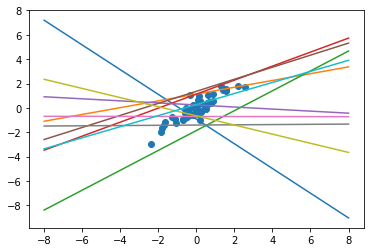

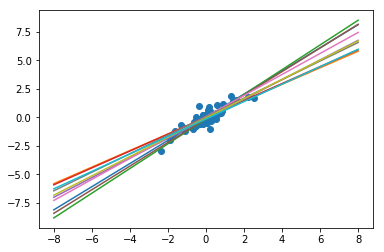

Define Visualize


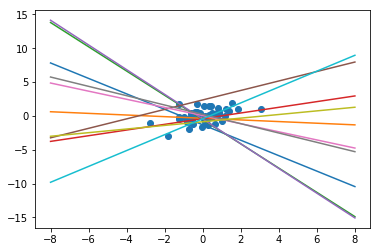

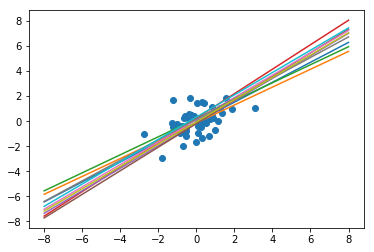

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
Finished 101  >  100


In [8]:

settings = {'training_data_function':build_toy_dataset}
init(settings)
i = 0
while run_step():
    i = i + 1
    print('.')
    #if i > 20:
    #    break



# The Model  becomes fit
It is possible to observe that, over time, as the network processes, that the model becomes progressivly more accurate at predicting the fluxuations. Several subjects are demonstrated:
1. graph based computation
2. objective orientation
3. usage of Edward, tensorflow
4. Normalization and the reverse
5. Drawing and estimating samples from bayesian distribution
6. stably stochastic data

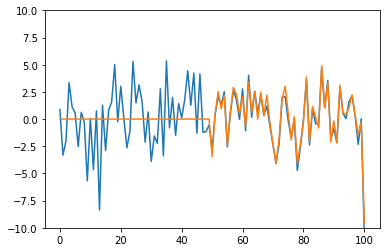

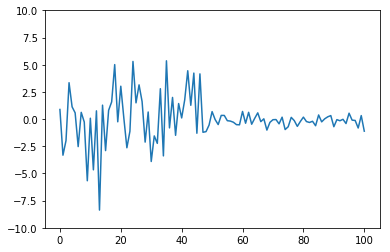

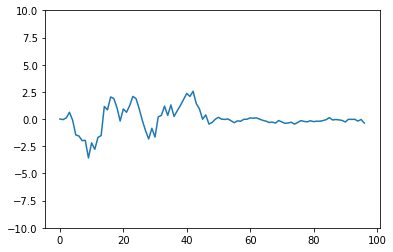

In [9]:
df = pd.DataFrame(dataStore)

diff = df['elevation'] - df['mean'] 
avg = np.convolve(diff, np.ones((5,))/5, mode='valid')

import matplotlib.pyplot as plt
plt.ylim((-10,10))
plt.plot(range(0,len(df['elevation'])),df['elevation'],df['mean'])
plt.show()

plt.ylim((-10,10))
plt.plot(range(0,len(df['elevation'])),diff)
plt.show()

plt.ylim((-10,10))
plt.plot(range(0,len(avg)),avg)
plt.show()